# HW2: Fun with Image Gradients

In this file we will explore the use of image gradients for edge detection.

We will 
* use the Sobel operator and the Gaussian derivative for edge detection
* explore the use of the fourier transform for edge detection
* perform the Laplacian pyramid decomposition and reconstruction
* corner detection using the Harris corner detector 
* and finally blob detection with the Gaussian pyramid

we will use the following functions and other from OpenCV:
`cv2.Sobel, cv2.GaussianBlur, cv2.pyrUp, cv2.pyrDown, cv2.magnitude`

we will also use the following and other functions from numpy:
`np.fft.fft2, np.fft.ifft2, np.fft.fftshift, np.fft.ifftshift, np.fft.fftshift, np.fft.ifftshift`

we will also use the following and other functions from matplotlib:
`plt.imshow, plt.subplot, plt.show, plt.title, plt.axis, plt.gray, plt.colorbar`

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.data
import skimage.io
import scipy.spatial

%matplotlib inline

Load an image (grayscale)

In [2]:
im = skimage.data.camera()

Some helper functions for performing a Fourier Trasnform:

In [3]:
# plot a fourier transform as an image
def show_ft(shift,subplt=111,title='FT Spectrum'):
    magnitude_spectrum = 20*np.log(np.abs(shift.copy()))
    if subplt != None:
        plt.subplot(subplt)
    plt.title(title)
    plt.imshow(magnitude_spectrum,cmap='Spectral',interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

# 2D Fourier Transform
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft2.html
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftshift.html
def ft(im,newsize=None):
    dft = np.fft.fft2(np.float64(im),newsize)
    return np.fft.fftshift(dft)

# perform the 2D Fourier Transform and show the result
def ft_and_show(im,subplt=111,newsize=None,title='FT Spectrum'):
    shift = ft(im, newsize)
    show_ft(shift, subplt, title)
    return shift

# Inverse 2D Fourier Transform
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.ifftshift.html
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.ifft2.html
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.abs.html
def ift(shift):
    f_ishift = np.fft.ifftshift(shift)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back)

# perform the inverse 2D Fourier Transform and show the result
def ift_and_show(shift,subplt=111,title='Reconstructed Image'):
    img_back = ift(shift.copy())
    if subplt != None:
        plt.subplot(subplt)
    plt.title(title)
    plt.imshow(img_back,cmap='gray',interpolation='nearest')
    return img_back

Given an image we apply any convolution kernel arbitrarily by transforming both image and kernel to the frequency domain.

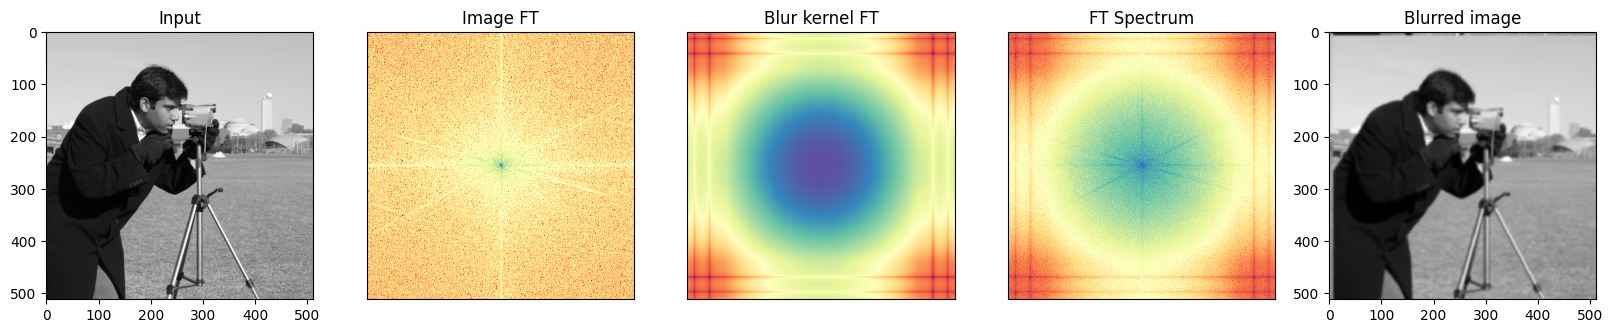

In [4]:
# Create a 17x17 Gaussian kernel
gk = cv2.getGaussianKernel(17,2)
gk = gk * gk.T

# Show the blur operation done by FT
plt.figure(figsize=(20,10))
plt.subplot(151),plt.imshow(im, cmap='gray'),plt.title('Input')
imf = ft_and_show(im, 152, (im.shape[1],im.shape[1]), 'Image FT') # image in F domain
ckf = ft_and_show(gk, 153, (im.shape[1],im.shape[1]), 'Blur kernel FT') # kernel in F domain
imconvf = imf * ckf # multiplication in Freq domain = convolution in spatial domain
show_ft(imconvf, 154)
# show_ft(imconvf / ckf, 155)
imconv = ift_and_show(imconvf, 155, 'Blurred image')

---
---

## Here comes your part

## Convolution Theorem

Deconvolve the image `imconv` given the (Gaussian) kernel that created it `gk`, and show the result. Use `ft` and `ift` functions from above.

This is what we'd expect:

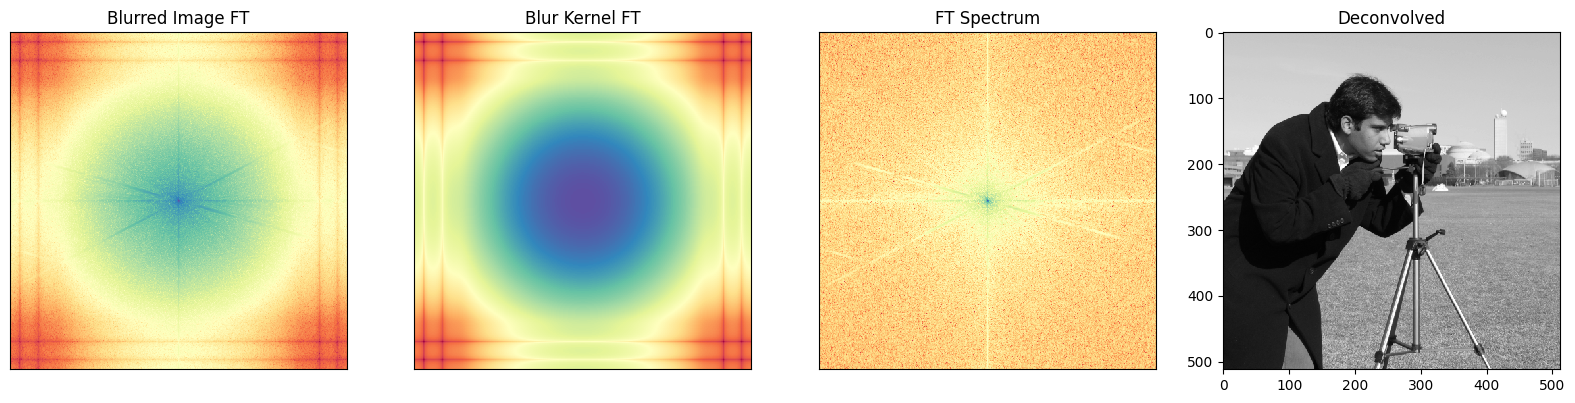

In [5]:
plt.figure(figsize=(20,10))
#TODO: your code, show the deconvolution process
# make sure sizes match so we can multiple easily, e.g. by supplying (im.shape[0],im.shape[1]) to ft_and_show
# get the FT of imconv, use 141 as the subplot number
imf = ft_and_show(imconv, 141, (im.shape[1],im.shape[1]), 'Blurred Image FT')
# get the FT of gk, use 142 as the subplot number
gkf = ft_and_show(gk, 142, (im.shape[1],im.shape[1]), 'Blur Kernel FT')
# in the frequency domain "de-apply" the kernel by dividing imf by it
deconvft = imf / gkf
# show the result of the division in the frequency domain (use 143 as the subplot number) using show_ft
show_ft(deconvft, 143)

# now reconstruct the blurred image from its FT
# use ift_and_show to show the result, supply deconvft and 144 as the subplot number
unblurred = ift_and_show(deconvft, 144, 'Deconvolved')

# plt.subplot(121),plt.imshow(imconv),plt.title('Blurred')
# plt.subplot(122),plt.imshow(unblurred),plt.title('Deconvolved')

C:\Users\User\AppData\Local\Temp\ipykernel_16800\1438511113.py:3: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(shift.copy()))


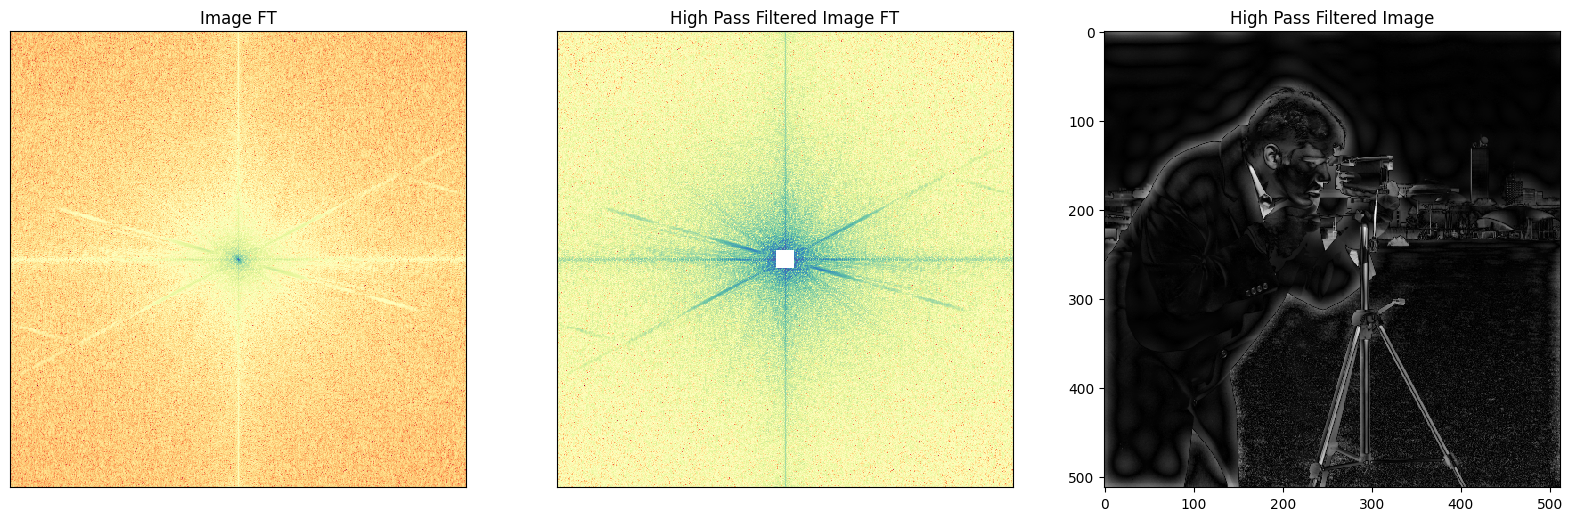

In [6]:
# apply a high pass filter to the fft of the image by setting the low frequencies to zero
# and then reconstruct the image from the filtered fft
plt.figure(figsize=(20,10))
imf = ft_and_show(im, 131, (im.shape[1],im.shape[1]), 'Image FT') # image in F domain
mid_width = imf.shape[1]//2
mid_height = imf.shape[0]//2
#TODO: your code, set the low frequencies to zero
# either by setting the values to zero (simple =0 assignment) or by multiplying by a mask
# or painting a circle of zeros on the center of the image (cv2.circle)
# e.g. imf[...] = ... goes here
imf[mid_height-10:mid_height+10,mid_width-10:mid_width+10] = 0

# using show_ft show the result of the high pass filter in the frequency domain (use 132 as the subplot number) 
show_ft(imf, 132, 'High Pass Filtered Image FT')
# using ift_and_show reconstruct the image from the filtered fft (use 133 as the subplot number)
imconv = ift_and_show(imf, 133, 'High Pass Filtered Image')

## Pyramid Blending

We will now implement the Laplacian pyramid blending algorithm.

(<Axes: >, <matplotlib.image.AxesImage at 0x1c2f3216360>)

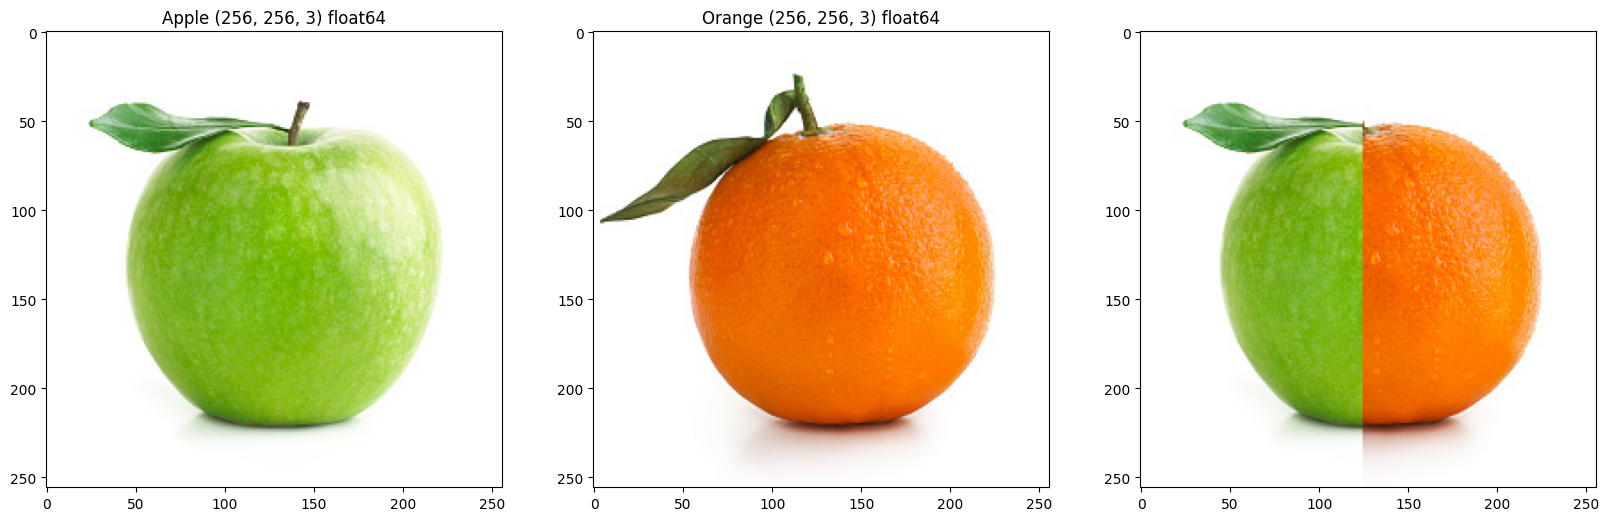

In [7]:
# here's an image of an apple and an orange
url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmedia.istockphoto.com%2Fphotos%2Fapple-and-orange-difference-picture-id637563258%3Fk%3D6%26m%3D637563258%26s%3D170667a%26w%3D0%26h%3DV3ZWrncLd8Fx8JdDODw0fCryk9-dimP9HS1wgwLsorI%3D&f=1&nofb=1&ipt=10e5cfd56eda60158ba3e0a3bc84a636c0fcda950b874a86ce42beeaf9866c73&ipo=images"
# load the image from the url and convert it to grayscale
im = skimage.io.imread(url) / 255.0
apple = im[60:316,246:]
orange = im[63:319,5:261]
# show the apple and the orange, and both fused together in the middle
plt.figure(figsize=(20,6))
plt.subplot(131),plt.imshow(apple),plt.title('Apple ' + str(apple.shape) + ' ' + str(apple.dtype))
plt.subplot(132),plt.imshow(orange),plt.title('Orange ' + str(orange.shape) + ' ' + str(orange.dtype))
plt.subplot(133),plt.imshow(np.hstack((apple[:,:125],orange[:,125:])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14783669810656225..1.059059269629294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.16755001984192097..1.059059269629294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34713529137007193..1.5360277974546235].


(<Axes: title={'center': 'Reconstructed'}>,
 Text(0.5, 1.0, 'Reconstructed'))

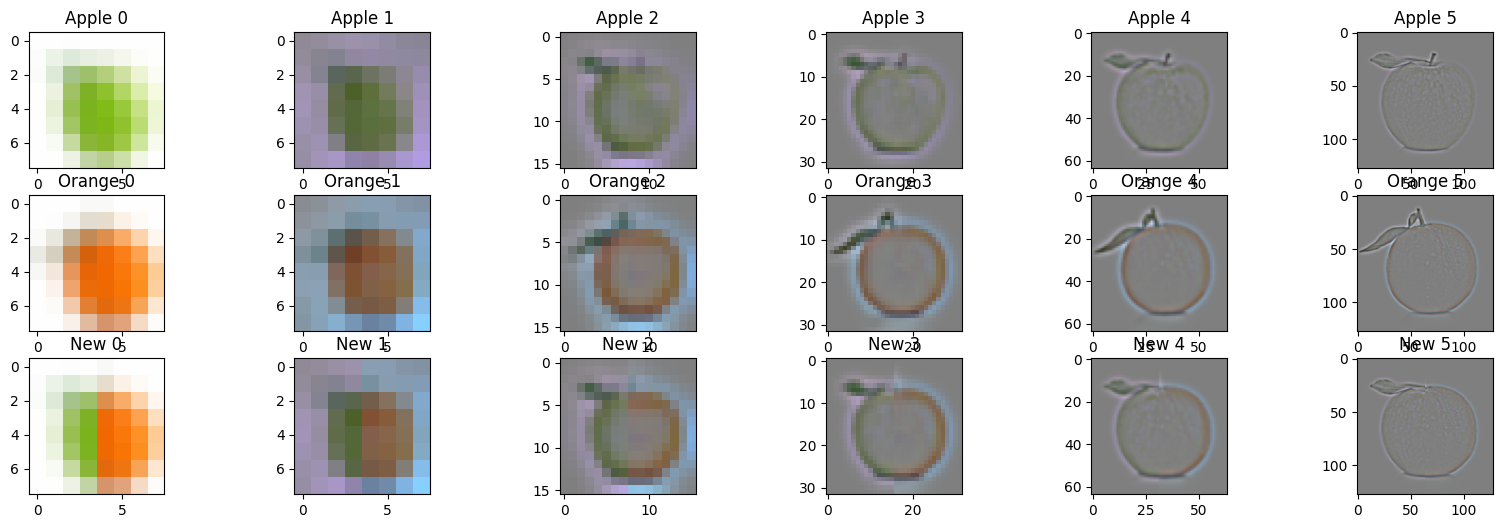

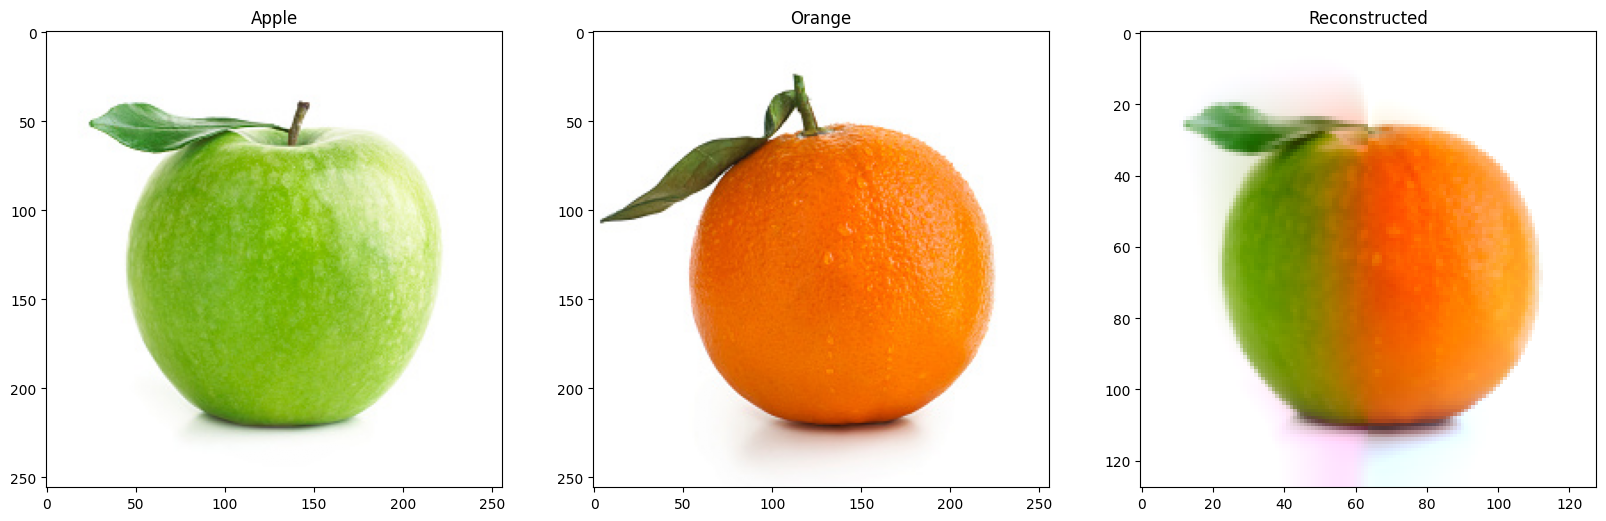

In [8]:
def buildLaplacianPyramid(G, levels=6):
    #TODO: your code here
    # Gaussian pyramid
    # initialize the Gaussian pyramid with the original image, G
    # and then build the Gaussian pyramid by repeatedly downsampling the image
    gpA = [G]
    for i in range(levels):
        # Blur and downsample the image to get the next level of the pyramid
        # using the cv2.pyrDown function
        G = cv2.pyrDown(G)
        # append the image to the pyramid
        gpA.append(G)

    # Laplacian pyramid
    # initialize the Laplacian pyramid with the last (smallest) level of the Gaussian pyramid
    # and then build the Laplacian pyramid by repeatedly upsampling the image and subtracting
    lpA = [gpA[levels-1]] # keep smallest Gaussian at bottom
    for i in range(levels,0,-1):
        # get the Gaussian at this level from the Gaussian pyramid and upsample it using cv2.pyrUp
        GE = cv2.pyrUp(gpA[i])

        # subtract the upsampled Gaussian in this from the Gaussian one level up, e.g. gpA[i-1]
        # to get (approximately) the Laplacian at this level
        L = cv2.subtract(gpA[i-1],GE)

        # append the result to the Laplacian pyramid
        lpA.append(L)
    
    # return the Laplacian pyramid
    return lpA

applePyr = buildLaplacianPyramid(apple)
orangePyr = buildLaplacianPyramid(orange)

#TODO: your code here
# combine applePyr + orangePyr to a new pyramid
newPyr = [] # initialize the new pyramid
for i in range(6):
    # get half of the width of the image at this level using the shape of the image and the int() 
    # function to round down to the nearest integer value (//2) 
    half_width_at_scale = int(applePyr[i].shape[1] // 2)

    # combine the two images at this level by stacking them side by side (np.hstack)
    # and append to the new pyramid list (newPyr.append)
    # the first half ([:,:half_width_at_scale]) of the image should be from the apple pyramid 
    # the second half ([:,half_width_at_scale:]) of the image should be from the orange pyramid
    newPyr.append(np.hstack((applePyr[i][:,:half_width_at_scale],orangePyr[i][:,half_width_at_scale:])))

# show apple, orange and new pyramids at all levels
plt.figure(figsize=(20,6))
for i in range(6):
    # add 0.5 to the image if it is not the smallest level of the pyramid (i > 0)
    # the smallest level of the pyramid (i == 0) is the original image, so we don't want to add 0.5
    # use plt.subplot to show the images in a 3x6 grid

    plt.subplot(3, 6, i + 1),plt.imshow(applePyr[i] + (0.5 if i > 0 else 0)),plt.title('Apple ' + str(i))
    plt.subplot(3,6,i+7),plt.imshow(orangePyr[i] + (0.5 if i > 0 else 0)),plt.title('Orange ' + str(i))
    plt.subplot(3,6,i+13),plt.imshow(newPyr[i] + (0.5 if i > 0 else 0)),plt.title('New ' + str(i))

#TODO: your code here
# reconstruct by adding HP to LP at each level.
recon = newPyr[0]
for i in range(1,6):
    # upsample the reconstructed image using cv2.pyrUp
    recon = cv2.pyrUp(recon)
    
    recon = cv2.resize(recon, (newPyr[i].shape[1], newPyr[i].shape[0]))

    
    # add the image at this level to the reconstructed image using cv2.add
    recon = cv2.add(recon,newPyr[i])

plt.figure(figsize=(20,6))
plt.subplot(131),plt.imshow(apple),plt.title('Apple')
plt.subplot(132),plt.imshow(orange),plt.title('Orange')
plt.subplot(133),plt.imshow(recon),plt.title('Reconstructed')

## Corner Detection
Implement the Harris corner detector.

Use the functions `cv2.Sobel` and `cv2.Gaussian Blur` to implement the Harris corner criteria:
$$
Harris(\hat{M}) = \det(\hat{M})-\alpha\mathrm{trace}(\hat{M}) \approx G(I_x^2)G(I_y^2)-G(I_xI_y)^2-\alpha[G(I_x^2)+G(I_y^2)]^2
$$
Where $G$ is the Gaussian blur operator, and $I_x,I_y$ are image derivatives (Sobel) in $x$ and $y$.

In [9]:
def harris(im, k = int(3), alpha = 0.05):
  # k is the kernel size for the Gaussian blue, alpha is the free parameter
  # TODO: your code here
  # compute the derivatives of the image in x and y directions using cv2.Sobel
  # https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d
  # to get the derivatives in x and y directions, use the dx = 1, dy = 0 and dx = 0, dy = 1 options
  dx = cv2.Sobel(im, ddepth=cv2.CV_64F, dx=1, dy=0)
  dy = cv2.Sobel(im, ddepth=cv2.CV_64F, dx=0, dy=1)

  # compute the gaussian blur of the derivatives in x-x, x-y and y-y directions using cv2.GaussianBlur
  # multiply the derivatives in x and y directions together to get the derivatives in x-y direction
  # and then blur them using cv2.GaussianBlur with the kernel size k [a 2D kernel (k,k)]
  dxx = cv2.GaussianBlur(dx**2, (k,k), 0)
  dyy = cv2.GaussianBlur(dy**2, (k,k), 0)
  dxy = cv2.GaussianBlur(dx*dy, (k,k), 0)

  # compute the harris response function using the formula above and return it
  return (dxx * dyy) - (dxy ** 2) - alpha * (dxx + dyy) ** 2

Here is an example of what this would look like:

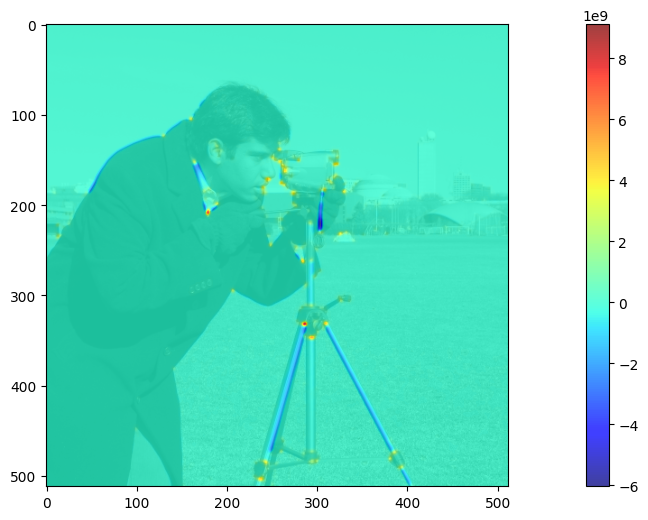

In [10]:
plt.figure(figsize=(20,6))
im = skimage.data.camera()
plt.imshow(im, cmap='gray')
har = harris(np.float32(im), 11, 0.05)
plt.imshow(har, cmap='jet', alpha=0.75),plt.colorbar();

Let's extract the feature points from the Harris response image

In [55]:
# find the local maxima points in the image
# the points are returned as a list of (x,y) tuples
def findLocalMaxima(im, threshold=50):
    #TODO: your code here
    # find the points that are above the threshold by using the numpy argwhere function
    # https://numpy.org/doc/stable/reference/generated/numpy.argwhere.html
    # first convert the image to a boolean array by comparing the image to the threshold (im > threshold)
    # the argwhere function returns the indices of the elements that are non-zero (i.e. True)
    # the result is a list of (row, column) tuples
    points = np.argwhere(im > threshold)

    # convert the list of (row, column) tuples to a list of (x, y) tuples
    points = [(p[1], p[0]) for p in points]

    # find the points that are the local maxima
    # by comparing the point to its 8 neighbors
    maxima = []
    for p in points:
    # check that the point is not on the border of the image (because it has fewer than 8 neighbors)
# the first element of the point is the row and the second element is the column
# the shape of the image is accessed using the shape attribute of the array
    # im.shape[0] is the number of rows and im.shape[1] is the number of columns
    # so check that the point is not on the first or last row or column
        # if the point is on the border, continue to the next point

        # e.g. if ... or ... or ... or ...:
        #    continue
        if p[0] <= 0 or p[0] >= im.shape[1]-1 or p[1] <= 0 or p[1] >= im.shape[0]-1:
            continue

        # check that the point is greater than or equal to all of its neighbors
        # the neighbors are the 8 pixels around the point (including diagonals)
        # the neighbors are accessed using array slicing with the syntax im[y1:y2, x1:x2]
        # where y1:y2 is the range of rows and x1:x2 is the range of columns
        # the range of rows and columns is inclusive on the lower bound and exclusive on the upper bound
        # so im[p[1]-1:p[1]+2, p[0]-1:p[0]+2] is the 3x3 array of pixels around the point p (x, y)
        # the np.all function returns true if all of the elements in the array are true
        # https://numpy.org/doc/stable/reference/generated/numpy.all.html

        # e.g. if np.all(...):
        # if the point is greater than or equal to all of its neighbors
        # then it is a local maximum and we add it to the list of maxima
        if np.all(im[p[1], p[0]] >= im[p[1]-1:p[1]+2, p[0]-1:p[0]+2]):
            maxima.append(p)

    return np.array(maxima)

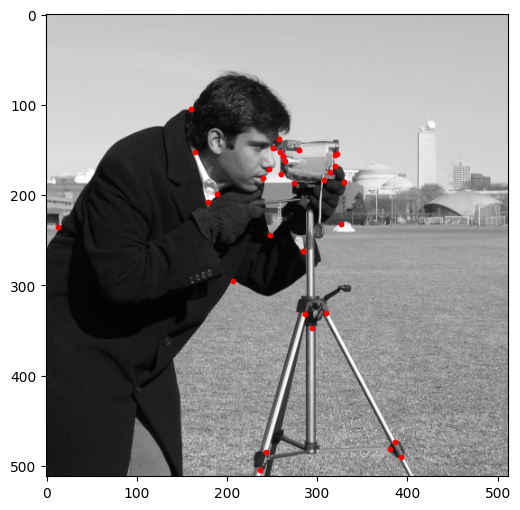

In [56]:
# find the local maxima points in the Harris response image har and plot them on top of the image
harris_points = findLocalMaxima(har, 2e9)
plt.figure(figsize=(20,6))
plt.imshow(im, cmap='gray')
plt.scatter(harris_points[:,0], harris_points[:,1], c='r', s=10)

Nice!

## Blob Detection

Implement a blob detector with the Difference of Gaussians using the Gaussian pyramid.

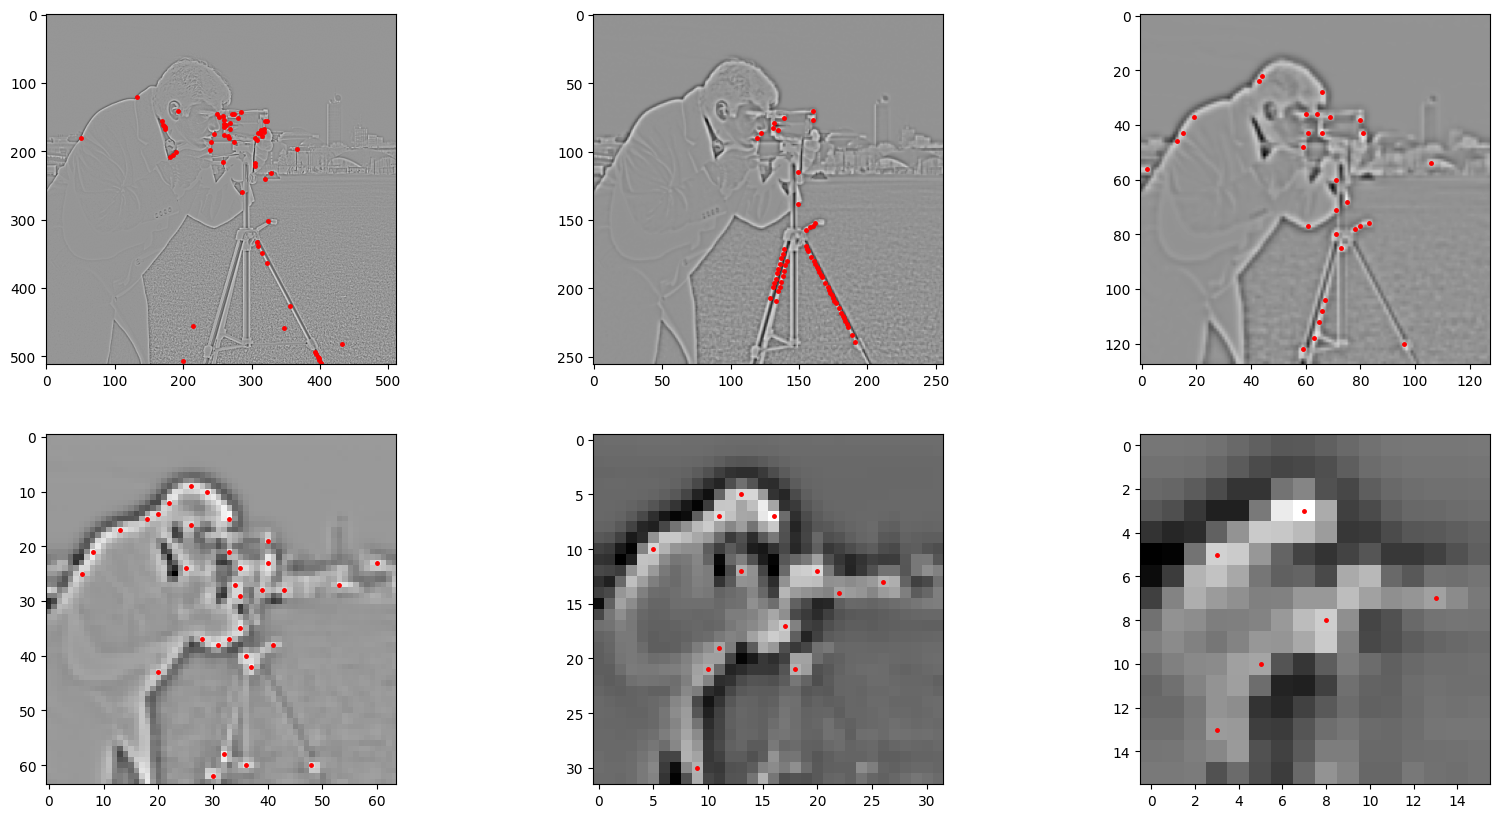

In [57]:
# calculate the difference of gaussians for the image in multiple scales
# by using the cv2.pyrDown function to downsample the image by a factor of 2
# and then subtracting the downsampled image from the original image
# the result is a pyramid of images, where each image is the difference of gaussians
# at a different scale.
# then find the maximum value in the pyramid and find the blobs by thresholding
# and applying simple non-maximum suppression.
def showDoGPyramid(im_u8, levels=6):
    im = np.float32(im_u8)
    plt.figure(figsize=(20,10))

    features = []

    prev = im
    for i in range(levels):
        #TODO: your code here
        # downsample the image by a factor of 2 by using the cv2.pyrDown function
        im = cv2.pyrDown(im)
        # subtract the downsampled image from the original image by first using the cv2.pyrUp function
        # to upsample the downsampled image to the original size and then subtracting the result

        upsampled = cv2.pyrUp(im, dstsize=(prev.shape[1], prev.shape[0]))

        dogim = cv2.subtract(upsampled, prev)
        # store the current image as the previous image for the next iteration
        prev = im

        # plot the image by using the plt.imshow function with the cmap='gray' parameter
        # in the subplot with 2 rows and 3 columns and the index i+1
        
        # plt.subplot(...) and plt.imshow(...) go here
        plt.subplot(2, 3, i+1)
        plt.imshow(dogim, cmap='gray')

        # find points that are local maxima in the image
        # and are above the threshold (set the threshold to 60 - 10*i)
        # use the findLocalMaxima function we defined above
        threshold = 60 - 10*i
        points = findLocalMaxima(dogim, threshold)
        
        # plot the points on the image
        # the points are returned as a list of (x,y) tuples
        # so we need to extract the x (e.g. p[0]) and y (e.g. p[1]) coordinates and plot them
        # use the plt.plot function with the 'r.' parameter to plot the points as red dots
        # and the markersize=5 parameter to set the size of the dots
        
        # plt.plot(...) goes here
        plt.plot([p[0] for p in points], [p[1] for p in points], 'r.', markersize=5)

        # add the points to the list of features, with the level of the pyramid as the third element
        # of the tuple
        # scale the x and y coordinates by a factor of 2**i
        # because the points are in the image at this level of the pyramid
        
        # features += [(..., ..., i) for p in points] goes here
        features += [(p[0] * 2**i, p[1] * 2**i, i) for p in points]

    plt.show()

    return features

found_featurs = showDoGPyramid(im)

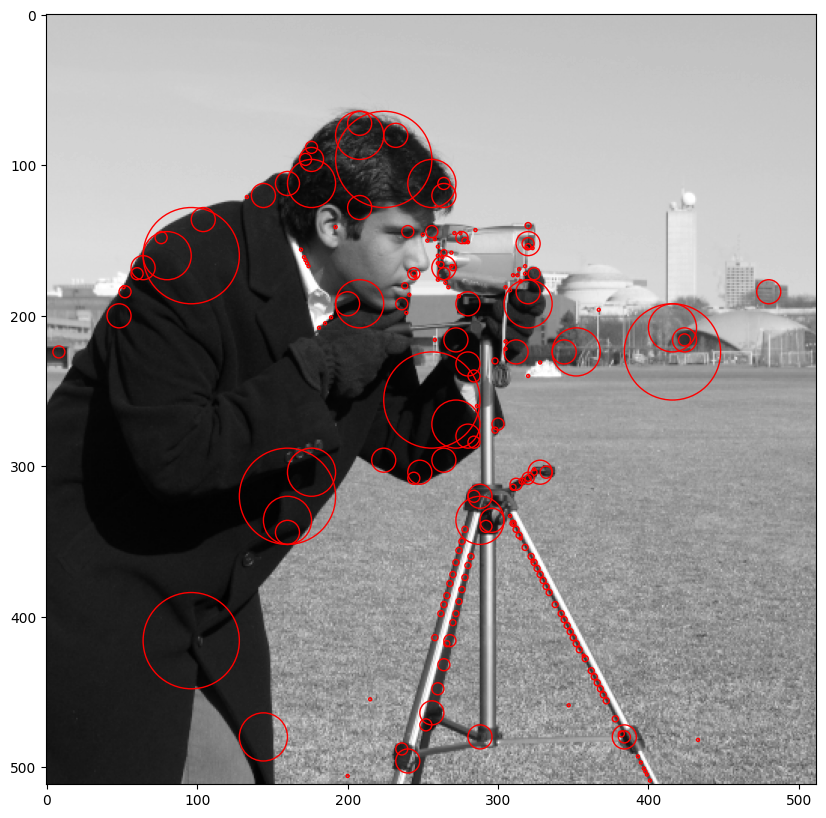

In [58]:
# plot the feature points on the image as circles with the level of the pyramid
# as the radius of the circle
def plotFeatures(im, features):
    plt.figure(figsize=(20,10))
    # plot the image
    plt.imshow(im, cmap='gray')
    # plot the circles
    # the features are returned as a list of (x,y,level) tuples
    for p in features:
        # use the plt.gca function to get the current axes, https://matplotlib.org/api/_as_gen/matplotlib.pyplot.gca.html
        # use the add_patch function to add a circle to the axes

        # the circle is created using the plt.Circle function, https://matplotlib.org/api/_as_gen/matplotlib.patches.Circle.html
        # the circle is centered at (p[0], p[1]) and has a radius of p[2]
        # scale the radius by a power of 2 (2**p[2]) because the points are in the image at this level of the pyramid
        
        # e.g. plt.gca().add_patch(...) goes here
        plt.gca().add_patch(plt.Circle((p[0], p[1]), 2**p[2], color='r', fill=False))

# plot the features on the image
plotFeatures(im, found_featurs)

## Orientation Estimation

Now we have a set of feature points, let's try to estimate their orientation.

In [59]:
# The simplest possible orientation estimate is the average gradient within a region around the keypoint.
def calculateOrientationForPoint(p, dx, dy):
    #TODO: your code here
    # get the x and y coordinates of the point
    x = p[0]
    y = p[1]
    angles = []
    # get the angle of the gradient vector for every pixel in a 5x5 window around the point
    for i in range(-2, 3):
        for j in range(-2, 3):
            # calculate the angle of the gradient vector
            # the angle of the gradient vector is the arctangent of the y gradient divided by the x gradient
            # the arctangent function returns an angle in radians, so we need to convert
            # the angle to degrees by multiplying by 180/pi
            # get the gradients from dx and dy at the point (x+i, y+j), e.g. dx[y+j,x+i]
            angle = np.arctan2(dy[y+j, x+i], dx[y+j, x+i]) * 180 / np.pi
            # add the angle to the list of angles
            angles.append(angle)

    # return the average angle using the np.mean function
    return np.mean(angles)

# calculate the dominant orientation for each feature point
def calculateDominantOrientation(im, features):
    #TODO: your code here
    # calculate the x and y gradients of the image
    # the sobel function returns the x and y gradients
    # the sobel function uses a 3x3 kernel, so the gradients are calculated at the center of each 3x3 kernel
    # the gradients are calculated at the center of each 3x3 kernel, so the gradients are offset by 1 pixel
    # from the edges of the image
    # use the cv2.Sobel function to calculate the gradients
    # the cv2.Sobel function takes the image, the data type, and the x and y derivatives
    # https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d
    # the data type is set to cv2.CV_64F to get a 64-bit float image
    # the x and y derivatives are set to 1 to get the x and y gradients
    # the cv2.Sobel function returns the x and y gradients as a tuple
    # the x gradient is the first element of the tuple and the y gradient is the second element
    dx, dy = cv2.Sobel(im, cv2.CV_64F, 1, 0), cv2.Sobel(im, cv2.CV_64F, 0, 1)

    # calculate the dominant orientation for each feature point
    orientations = []
    for p in features:
        # calculate the dominant orientation for the point
        # the calculateOrientationForPoint function returns the angle of the gradient vector
        # at the point p
        # use the calculateOrientationForPoint function we defined above
        angle = calculateOrientationForPoint(p, dx, dy)
        # add the angle to the list of orientations
        orientations.append(angle)

    return orientations

# calculate the dominant orientation for each feature point
found_orientations = calculateDominantOrientation(im, found_featurs)

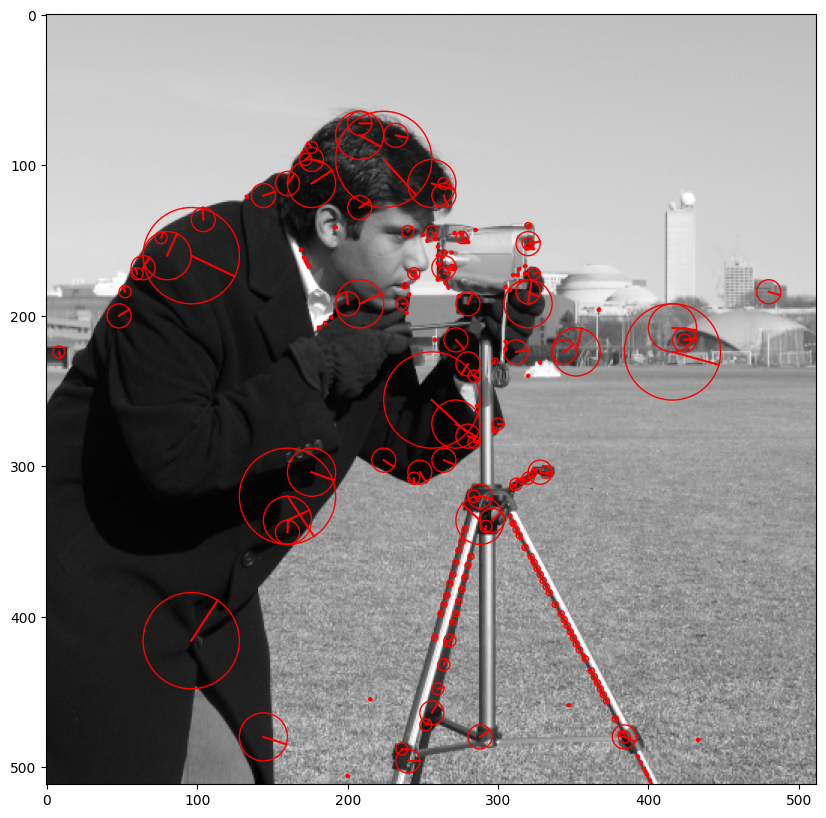

In [60]:
# plot the orientations on the image
def plotOrientations(im, features, orientations):
    #TODO: your code here
    # set the figure size to 10x10
    # plt.figure(...) goes here
    plt.figure(figsize=(10,10))

    # plot the image
    # plt.imshow(...) goes here
    plt.imshow(im, cmap='gray')

    # plot the circles
    # the features are returned as a list of (x,y,level) tuples and the orientations are returned as a list of angles
    for p, angle in zip(features, orientations):
        # use the plt.gca function to get the current axes, https://matplotlib.org/api/_as_gen/matplotlib.pyplot.gca.html
        # use the add_patch function to add a circle to the axes
        # the circle is created using the plt.Circle function, https://matplotlib.org/api/_as_gen/matplotlib.patches.Circle.html
        # the circle is centered at (p[0], p[1]) and has a radius of p[2]
        # scale the radius by a power of 2 (2**p[2]) because the points are in the image at this level of the pyramid
        
        # plt.gca().add_patch(plt.Circle(...)) goes here
        plt.gca().add_patch(plt.Circle((p[0], p[1]), 2**p[2], color='r', fill=False))

        # plot the line from the center of the circle to the edge of the circle
        # the angle of the line is the angle of the gradient vector at the point
        # the angle is in degrees, so we need to convert it to radians by multiplying by pi/180
        # the length of the line is the radius of the circle, e.g. 2**p[2]
        # the x and y coordinates of the end of the line are the x and y coordinates of the center
        # plus the length of the line times the cosine (for x) and sine (for y) of the angle
        # e.g. [p[0], p[0] + 2**p[2] * np.cos(...)] for the x coordinates
        plt.plot([p[0], p[0] + 2**p[2] * np.cos(angle * np.pi / 180)], [p[1], p[1] + 2**p[2] * np.sin(angle * np.pi / 180)], 'r')

# plot the orientations on the image
plotOrientations(im, found_featurs, found_orientations)

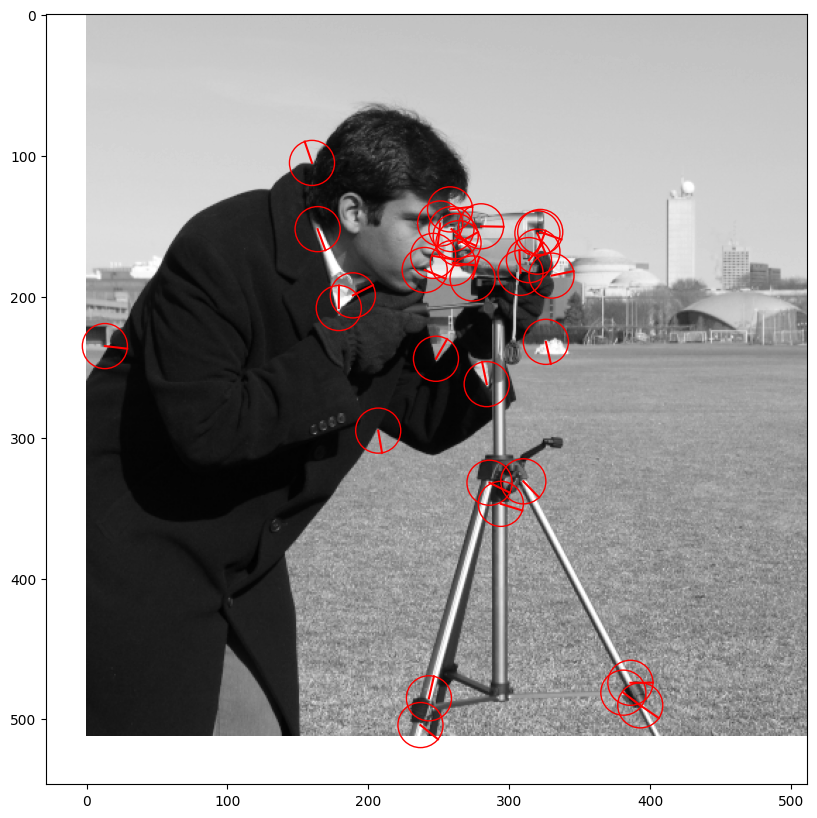

In [61]:
#TODO: your code here

# calculate the dominant orientation for each feature point in the harris_points list
# using the calculateDominantOrientation function we defined above
found_orientations = calculateDominantOrientation(im, harris_points)

# plot the orientations for the harris_points on the image
# but first add a mock level scale (e.g. 4) to the harris_points list, so the plotOrientations function works
# the plotOrientations function expects a list of (x,y,level) tuples
# but the harris_points list is a list of (x,y) tuples
# augment the harris_points list with a mock level scale (e.g. 4) to make it a list of (x,y,level) tuples
harris_points_with_level_scale = [(p[0], p[1], 4) for p in harris_points]

# plot the orientations on the image
plotOrientations(im, harris_points_with_level_scale, found_orientations)

That's a wrap!